## Exploratory Data Analysis and Pre-Model Cleaning

In this notebook, we analyze the data containing call and put prices from Apple (AAPL). We will take a look at the basic features we are working with, as well clean the data to prepare it for modeling using ML methods. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
aapl_df = pd.read_pickle('/home/jul-ian/Github/ml-options/data/processed/stocks_df/aapl_df.pkl')

print(aapl_df.columns)
aapl_df.head()

Index(['date_priced', 'date_expired', 'days_to_maturity', 'stock_bid',
       'stock_ask', 'option_bid', 'option_ask', 'strike_price', 'option_type',
       'rf_rate'],
      dtype='object')


,date_priced,date_expired,days_to_maturity,stock_bid,stock_ask,option_bid,option_ask,strike_price,option_type,rf_rate
0,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,130.0,put,0.017294
1,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,135.0,put,0.017294
2,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,140.0,put,0.017294
3,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.05,142.0,put,0.017294
4,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.07,143.0,put,0.017294


The Black-Scholes formula for the price of a call (C = N(d_1)S_t - N(d_2)Ke^(-rt)) includes the price of the stock at time t. But in the real world, there are separate prices at which buyers are willing to buy, and sellers are willing to sell. The maximum at which a buyer will buy is the bid price, while the lowest the seller will sell is the ask price. The ask price is usually higher than the bid, and the difference is referred to as the bid-ask spread. As an initial simplification, we will take the midpoint of the bid and ask to be the input price. We will also do this for the price of the option, since it also has bid and ask prices.

In [3]:
aapl_df['stock_mid'] = (aapl_df['stock_bid'] + aapl_df['stock_ask']) / 2
aapl_df['option_mid'] = (aapl_df['option_bid'] + aapl_df['option_ask']) / 2

We see that the 'option_type' column denotes whether the option is as call or put. At this initial stage, for simplicity, we will focus on just calls.

In [4]:
display(aapl_df['option_type'].value_counts().sort_index())

aapl_call_df = aapl_df[aapl_df['option_type'] == 'call']

aapl_call_df.shape

call    492384
put     483595
Name: option_type, dtype: int64

(492384, 12)

We will take a look at the stock and option prices first.

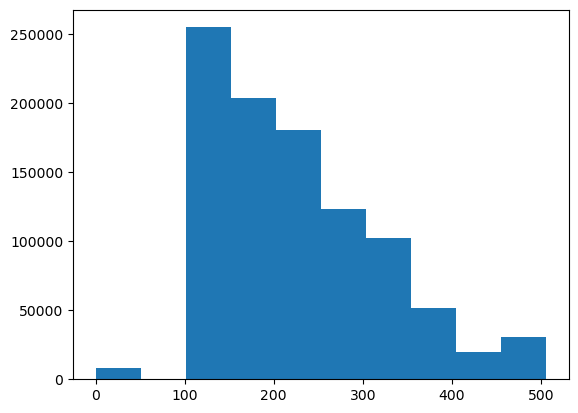

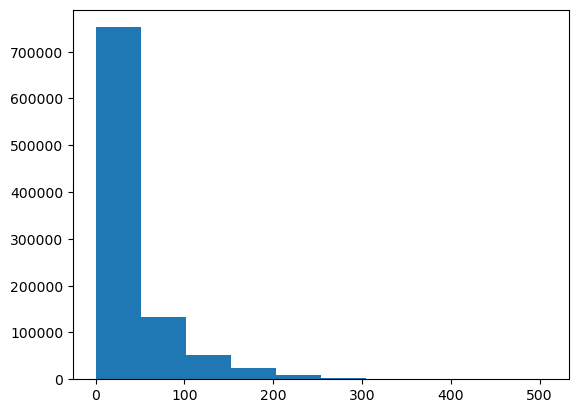

In [13]:
plt.hist(aapl_df['stock_mid'])
plt.show()

plt.hist(aapl_df['option_mid'])
plt.show()